![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )


#Portfolio Selection using MOSEK Optimizer API


Portfolio selection (or portfolio management) is the art and science of making decisions about investment mix and policy, matching investments to objectives, asset allocation for individuals and institutions, and balancing risk against performance.

The aim of this tutorial is two-fold:

1. to show some modeling techniques to define portfolio selections problems;
2. to show how to efficiently implement those problems using MOSEK Optimizer API.


This tutorial is largerly based on:

    [1] Bai, X., Scheinberg, K., Tutuncu, R. (2013). Least-squares approach to risk parity in portfolio selection

The code is written in Python2 and uses the [MOSEK Optimizer API](https://mosek.com/resources/doc) version 7.1.

#The basics

Consider the problem of an investor, who has to invest his money in $n$ different assets. Which allocation strategy should he use to obtain the maximum $\textit{benefit}$ from his investment?

Let $x_1, x_2, .. , x_n$ be the percentage of money invested in assets $1,2,..,n$. Every asset has his mean $\mu_i$ and his variance $\sigma^2_i$ and assume to know the covariance between different assets $\sigma_{i,j}$. Let $\Sigma$ be the covariance matrix, with elements $\Sigma_{i,j} = \sigma_{i,j}$. We can then define two global measures of the whole portfolio:
$$
\mu =\sum_{i=1}^n \mu_i x_i
$$

$$
\sigma^2 = \sum_{i=1}^n \sum_{j=1}^n \sigma_{i,j}x_i x_j = x^T \Sigma x
$$

For different choices of $x_1, ..., x_n$ the investor will get different combinations of $\mu$ and $\sigma^2$. The set of all possible ($\sigma^2$, $\mu$) combinations is called the $\textit{attainable set}$. Those ($\sigma^2$, $\mu$) with minimum $\sigma^2$ for a given $\mu$ or more and maximum $\mu$ for a given $\sigma^2$ or less are called the $\textit{efficient set}$ (or efficient frontier).
![Efficient Frontier](http://i67.tinypic.com/296dxfr.png)
The solution of the following $\textit{convex}$ optimization problem lies in the efficient set:

$$
\begin{aligned}
&\min_x &&\frac{1}{2}x^T \Sigma x\\
&\text{s.t.}
&&\mu^T x \geq R\\
&&&\sum\limits_{i=1}^n x_i=1\\
&&&x \geq 0
\end{aligned}
$$

where $R$ is a lower bound on the target expected return of the portfolio. The above problem is often referred as $\textbf{Mean-Variance Optimization (MVO)}$. The main problems of the mean-variance approach are three:
* tends to produce portfolios with unreasonably large weights for certain asset 
* difficulty of estimating expected returns accurately
* sensitivity of the optimal weights to small changes in expected returns

#Risk Parity





Unlike the classic mean-variance approach, risk based strategies do not incorporate expected returns into the formulation. With $\textit{risk}$ is intended a measurement of the likelihood that an investment will go up and down in value, and how often and by how much. The theory assumes that investors prefer to minimize risk; in fact, it assumes that given the choice of two portfolios with equal returns, investors will choose the one with the least risk.

In a fully-invested portfolio, every asset $i$ has his contribution in terms of risk. Let $RC_i(x)$ be this contribution, we have that the total risk of the invested portfolio is:

$$
\mathcal{R}(x) = \sum_{i=1}^n RC_i(x)
$$

where

$$
RC_i(x) = x_i \frac{\delta \mathcal{R}(x)}{\delta x_i}
$$

Let $b=(b_1,..,b_n)$ be a vector of $\textbf{budgets}$ such as $b_i > 0$ and $\sum_{i=1}^n b_i = 1$. The simplest way to define a risk parity (or risk budgeting) portfolio is through the following system of constraints:

$$
\begin{aligned}
&\begin{cases}
RC_1(x) = b_1 \mathcal{R}(x)\\
..\\
RC_i(x) = b_i \mathcal{R}(x)\\
..\\
RC_n(x) = b_n \mathcal{R}(x)
\end{cases}
\end{aligned}
$$

From the above equations, we can write the risk parity constraint as:

$$
x_i \frac{\delta_{x_i} \mathcal{R}(x)}{b_i} = x_j \frac{\delta_{x_j} \mathcal{R}(x)}{b_j} \hspace{1em} \forall i,j
$$

The Risk Parity portfolio is defined by this system of equations:

$$
\begin{aligned}
&x_i \frac{\delta_{x_i} \mathcal{R}(x)}{b_i} = x_j \frac{\delta_{x_j} \mathcal{R}(x)}{b_j} \hspace{1em} &&\forall i,j\\
&x_i \geq 0,  &&b_i > 0 \\
&\sum_{i=1}^n x_i = 1,  &&\sum_{i=1}^n b_i = 1
\end{aligned}
$$

If we set

$$
\mathcal{R}(x) = \sqrt{x^T\Sigma x}
$$

solve the following problem that incorporates a logarithmic barrier in the objective function is equivalent to find a Risk Parity solution:

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&\frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n} b_i ln(x_i)\\
& \text{s.t.}
&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$

where $b_i > 0$, $\sum_i b_i = 1$ and $c$ is a positive constant.

$\textit{Proof.}$ Since $\Sigma$ is positive semidefinite and the logarithm function is strictly concave, the objective function is $\textbf{strictly convex}$. From the first order condition, the unique solution is in corrispondence of the point where the gradient of the objective function is zero:

$$
\Sigma x - c b_i x^{-1} = 0
$$

Hence, at optimality we have

$$
(\Sigma x)_i = \frac{c b_i}{x_i} \Rightarrow \frac{x_i(\Sigma x)_i}{b_i} = \frac{x_j(\Sigma x)_j}{b_j}, \quad \forall i,j
$$


#MOSEK Implementation

First of all, we have to import the MOSEK library into the project. Before setting up the optimization problem, a MOSEK $\textbf{environment}$ must be created. All tasks in the program should share the same environment.

In [100]:
import mosek
import numpy as np

env = mosek.Env()

Next, an empty $\textbf{task}$ object is created:

In [101]:
task = env.Task()

Now, we create some sample data. In this case we have 5 assets and we randomly generate a semidefinite-positive covariance matrix.

In [102]:
n = 10

A = np.random.sample([n,n])

#Q is our covariance matrix
Q = np.dot(A,A.transpose())

#b is the vector of budgets 
b = np.random.sample(n)
b = b/np.sum(b)

For this type of problem, we have $n$ variables and $1$ constraint. So we set them into the task:

In [103]:
numvar = n
numcon = 1

task.appendvars(numvar)
task.appendcons(numcon)

We have to write the constraint $x>0$. The bounds on variables are stored in the arrays:

In [104]:
# Bound keys for variables 
bkx = [mosek.boundkey.lo] * n
    
# Bound values for variables 
blx = np.zeros(n)
bux = [np.infty] * n

Now we have to set the bounds for every variable $x_j$ with a loop:

In [105]:
for j in range(numvar):
    task.putbound(mosek.accmode.var, j, bkx[j], blx[j], bux[j])

The next step is to write down the objective function. Since the covariance matrix $\Sigma$ is symmetric, we can use only his upper-triangle:

In [106]:
#extract the indexes of the upper-triangle of the covariance matrix
indexes = np.tril_indices(numvar)
qsubi = indexes[0]
qsubj = indexes[1]

#create the upper-triangle matrix with the indexes previously extracted
qval = np.tril(Q)[indexes]

Now, we can add the first part of the objective function to the task:

In [107]:
task.putqobj(qsubi,qsubj,qval)

Now, we have to add the logarithmic term to the objective function. In MOSEK, logarithm is seen as an instance of a $\textbf{separable term}$. Each individual term can be describes by a set of values:

In [108]:
#define the logarithm for n variables
opro = [mosek.scopr.log] * n 

#define the variable indexes
oprjo = np.array([i for i in range(n)])

#define the multiplicative term (in this case we assume c=1)
oprfo = -b

#define the exponential terms
oprgo = np.ones(n)

#define the additive terms
oprho = np.zeros(n)

We can now input the separable terms using the $Task.putSCeval$ function:

In [109]:
task.putSCeval(opro, oprjo, oprfo, oprgo, oprho)

Now we have to tell to the optimizer that is a minimization problem:


In [110]:
# Input the objective sense (minimize/maximize) 
task.putobjsense(mosek.objsense.minimize) 

Finally, we call the optimization routine:

In [111]:
task.optimize()

ok

We can access to the optimal solution found through two simple instructions:

In [112]:
xx = np.zeros(numvar, float)
task.getxx(mosek.soltype.itr,xx)

If we also want that $\sum_{i=1}^n x_i = 1$ we normalize the solution:

In [113]:
xx = xx/np.sum(xx)

Now we can see the Risk Parity solution in a bar chart:

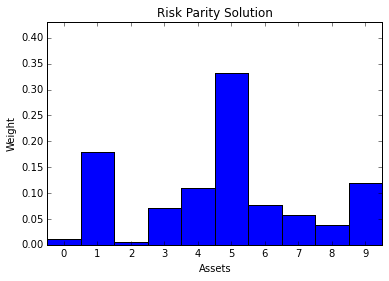

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline


# the histogram of the data

ind = np.arange(n)
width = 1
fig, ax = plt.subplots()
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Risk Parity Solution')
ax.set_xticks(ind + 0.5)
ax.set_xticklabels(ind)
rects1 = ax.bar(ind, xx, width)
plt.axis([0, n, 0, np.max(xx)+0.1])
plt.show()


A Risk Parity solution satisfies the following equation:
    
$$
\frac{RC_i(x)}{x^T \Sigma x} = b_i \quad \forall i \in \{1,..,n\}
$$

To verify that this is really a Risk Parity solution, we now compute the marginal risk contributions for all assets:

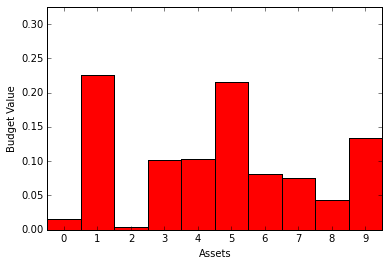

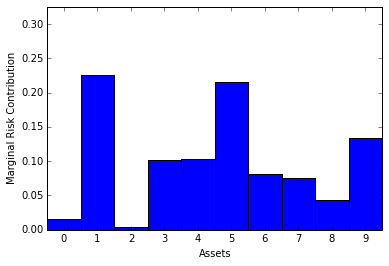

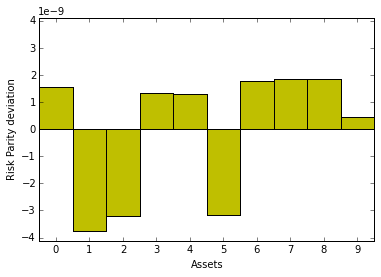

In [115]:
RC = np.zeros(n)
aux = Q.dot(xx)
volatility = xx.dot(aux)
for i in range(n):
    RC[i]=xx[i]*aux[i]/volatility
    
ind = np.arange(n)
width = 1

#print budget vector
fig, ax2 = plt.subplots()
plt.xlabel('Assets')
plt.ylabel('Budget Value')
ax2.set_xticks(ind + 0.5)
ax2.set_xticklabels(ind)
rects2 = ax2.bar(ind, b, width, color='r')
plt.axis([0, n, 0, np.max(b)+0.1])
plt.show()

#print marginal risk contribution
fig, ax = plt.subplots()
plt.xlabel('Assets')
plt.ylabel('Marginal Risk Contribution')
ax.set_xticks(ind + 0.5)
ax.set_xticklabels(ind)
rects1 = ax.bar(ind, RC, width)
plt.axis([0, n, 0, np.max(RC)+0.1])
plt.show()

#print the differences between the two above
fig, ax3 = plt.subplots()
plt.xlabel('Assets')
plt.ylabel('Risk Parity deviation')
ax3.set_xticks(ind + 0.5)
ax3.set_xticklabels(ind)
rects3 = ax3.bar(ind, RC-b, width, color='y')
bound = np.max(np.abs(np.min(RC-b)), np.abs(np.max(RC-b)))
plt.axis([0, n, -1.1*bound, 1.1*bound])
plt.show()

